In [1]:
import numpy as np
import cvxopt
import matplotlib.pyplot as plt

cvxopt.solvers.options['show_progress'] = False

In [2]:
# Data analysis

from sklearn.model_selection import train_test_split

X = np.genfromtxt('mush_features.csv')
Y = np.genfromtxt('mush_labels.csv')
    
train_set_x, test_set_x, train_set_y, test_set_y = train_test_split(X, Y, test_size=0.33, random_state=42)
print('train_set_x.shape: ', train_set_x.shape)
print('test_set_x.shape: ', test_set_x.shape)
print('train_set_y.shape: ', train_set_y.shape)
print('test_set_y.shape: ', test_set_y.shape)

train_set_x.shape:  (5175, 22)
test_set_x.shape:  (2549, 22)
train_set_y.shape:  (5175,)
test_set_y.shape:  (2549,)


In [3]:
import pandas as pd

df1 = pd.DataFrame(test_set_x)
df1.head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,2.0,2.0,2.0,0.0,7.0,1.0,0.0,1.0,0.0,1.0,...,2.0,6.0,7.0,0.0,2.0,1.0,0.0,7.0,4.0,4.0
1,5.0,3.0,4.0,1.0,5.0,1.0,0.0,0.0,10.0,1.0,...,2.0,7.0,3.0,0.0,2.0,1.0,4.0,2.0,5.0,0.0
2,3.0,3.0,2.0,0.0,7.0,1.0,0.0,1.0,0.0,1.0,...,1.0,6.0,6.0,0.0,2.0,1.0,0.0,7.0,4.0,2.0
3,5.0,0.0,3.0,0.0,5.0,1.0,1.0,0.0,3.0,1.0,...,2.0,7.0,7.0,0.0,2.0,1.0,0.0,2.0,0.0,1.0
4,5.0,2.0,2.0,0.0,8.0,1.0,0.0,1.0,0.0,1.0,...,1.0,6.0,6.0,0.0,2.0,1.0,0.0,7.0,4.0,4.0


In [4]:
df2 = pd.DataFrame(test_set_y)
df2.head()

,0
0,1.0
1,-1.0
2,1.0
3,-1.0
4,1.0


In [5]:
def load_data():
        
    X = np.genfromtxt('mush_features.csv')
    Y = np.genfromtxt('mush_labels.csv')
    
    train_set_x, test_set_x, train_set_y, test_set_y = train_test_split(X, Y, test_size=0.33, random_state=42)
    
    train_set_x = train_set_x[:300].astype(float)
    train_set_y = train_set_y[:300].astype(float)
    
    test_set_x = test_set_x[:100].astype(float)
    test_set_y = test_set_y[:100].astype(float)
    
    x_test = train_set_x[:5]
    y_test = train_set_y[:5]   
    
    train_set_x = train_set_x.reshape(train_set_x.shape[0], -1).T
    test_set_x = test_set_x.reshape(test_set_x.shape[0], -1).T
    
    train_set_y = train_set_y.reshape((1, train_set_y.shape[0]))
    test_set_y = test_set_y.reshape((1, test_set_y.shape[0]))
    
    x_test = x_test.reshape(x_test.shape[0], -1).T
    y_test = y_test.reshape((1, y_test.shape[0]))
    
    return train_set_x, test_set_x, train_set_y, test_set_y, x_test, y_test

In [6]:
train_set_x, test_set_x, train_set_y, test_set_y, x_test, y_test = load_data()
print('train_set_x.shape: ', train_set_x.shape)
print('test_set_x.shape: ', test_set_x.shape)
print('train_set_y.shape: ', train_set_y.shape)
print('test_set_y.shape: ', test_set_y.shape)

train_set_x.shape:  (22, 300)
test_set_x.shape:  (22, 100)
train_set_y.shape:  (1, 300)
test_set_y.shape:  (1, 100)


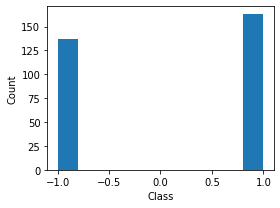

In [7]:
plt.figure(figsize=(4, 3))
plt.hist(train_set_y.T)
plt.xlabel("Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

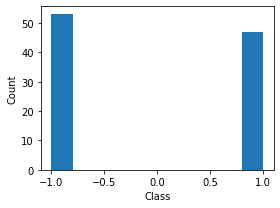

In [8]:
plt.figure(figsize=(4, 3))
plt.hist(test_set_y.T)
plt.xlabel("Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [9]:
# Kernels

class Kernel(object):
    def linear():
        """
            Returns:
            function that takes two vectors as a parameters and returns their dot product
        """
        
        return lambda x, y: np.dot(x, y)        
        
    def polynomial(coef, power):
        """
            Arguments:
            coef: float
            power: int
        
            Returns:
            function that takes two vectors as a parameters and computes polynomial kernel
        """
        
        return lambda x, y: (np.dot(x, y) + coef) ** power        
        
    def rbf(gamma):
        """
            Arguments:
            gamma: float
        
            Returns:
            function that takes two vectors as a parameters and computes rbf kernel
        """
        
        return lambda x, y: np.exp(-gamma * (np.linalg.norm(x - y, 2) ** 2))

In [10]:
lin = Kernel.linear()
polynom = Kernel.polynomial(3, 2)
rbf = Kernel.rbf(0.0002)

xt = x_test[:, 1]
yt = x_test[:, 2]

print('linear_kernel: ', lin(xt, yt))
print('polynomial_kernel: ', polynom(xt, yt))
print('rbf_kernel: ', rbf(xt, yt))

linear_kernel:  202.0
polynomial_kernel:  42025.0
rbf_kernel:  0.9906440418940348


In [11]:
# SVM

class SVM(object):
    """
    The Support Vector Machines classifier
    
    Arguments:
    C -- penalty term  
    kernel -- kernel function e.g. lambda x, y: ...
    """
    def __init__(self, C=1, kernel=Kernel.linear()):
        self.C = C
        self.kernel = kernel
        self.non_zero_multipliers = None
        self.support_vectors = None
        self.support_labels = None
        self.b = None
    
    def _kernel_matrix(self, X):
        """
        Computes kernel matrix applying kernel function pairwise for each sample

        Arguments:
        X -- input matrix of shape (number of features, number of samples)
        
        Returns:
        kernels matrix of shape (number of samples, number of samples)
        """
        
        # Get number of samples
        n_samples = X.shape[1]
        
        # Calculate kernels pairwise and fill kernels matrix        
        K = np.zeros((n_samples, n_samples))
        func = self.kernel
        K_temp = func(X.T, X)        

        # Return kernel matrix
        return K + K_temp
    

    def _compute_lagrange_multipliers(self, X, Y):
        """
        Solves the quadratic optimization problem and calculates lagrange multipliers

        We need to solve
            min 1/2 x^T P x + q^T x (aplha is x)
        s.t.
            Gx <= h (alpha >= 0)
            Ax = b (y^T * alpha = 0)

        Arguments:
        X -- input matrix of shape (number of features, number of samples)
        Y -- labels of shape (1, number of samples)

        Returns:
        numpy array of lagrange multipliers
        """
        
        # Get number of samples
        n_samples = X.shape[1]
        
        # Get Kernel matrix by calling _kernel_matrix function
        K = self._kernel_matrix(X)

        # Create create quadratic term P based on Kernel matrix
        P = cvxopt.matrix(np.outer(Y, Y) * K)
        
        # Create linear term q
        q = cvxopt.matrix(np.ones(n_samples) * -1)

        # Create G, h
        if not self.C:
            G = cvxopt.matrix(np.identity(n_samples) * -1)
            h = cvxopt.matrix(np.zeros(n_samples))
        else:
            G_max = np.identity(n_samples) * -1
            G_min = np.identity(n_samples)
            
            G = cvxopt.matrix(np.vstack((G_max, G_min)))
            
            h_max = cvxopt.matrix(np.zeros(n_samples))
            h_min = cvxopt.matrix(np.ones(n_samples) * self.C)
            
            h = cvxopt.matrix(np.vstack((h_max, h_min)))
        
        # Create A, b
        A = cvxopt.matrix(Y, (1, n_samples))
        b = cvxopt.matrix(0.0)

        # Solve the quadratic optimization problem using cvxopt
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)
        
        # Extract flat array of lagrange multipliers
        lagrange_multipliers = np.ravel(solution['x'])

        # Return lagrange multipliers
        return lagrange_multipliers   
    

    def _get_support_vectors(self, lagrange_multipliers, X, Y):
        """
        Extracts the samples that will act as support vectors and corresponding labels

        Arguments:
        lagrange_multipliers -- numpy array of lagrange multipliers
        X -- input matrix of shape (number of features, number of samples)
        Y -- labels of shape (1, number of samples)

        Returns:
        non_zero_multipliers -- numpy array of non-zero lagrange multipiers (>1e-7)
        support_vectors -- matrix of support vectors of shape (number of features, number of support vectors)
        support_vector_labels -- corresponding labels of shape (1, number of support vectors)
        """
        
        # Get indexes of non-zero lagrange multipiers
        idx = lagrange_multipliers > 1e-7
        
        # Get the corresponding lagrange multipliers
        non_zero_multipliers = lagrange_multipliers[idx]
        
        # Get the samples that will act as support vectors
        support_vectors = X[:, idx]
        
        # Get the corresponding labels
        support_labels = Y[0, idx]
        support_labels = support_labels[np.newaxis, :] 
        
        # Return 
        return non_zero_multipliers, support_vectors, support_labels
        

    def fit(self, X, Y):
        """
        Main training function

        Arguments:
        X -- input matrix of shape (number of features, number of samples)
        Y -- labels of shape (1, number of samples)
        """
        
        # Solve the quadratic optimization problem and get lagrange multipliers
        lagrange_multipliers = self._compute_lagrange_multipliers(X, Y)

        # Extract support vectors and non zero lagrange multipliers
        self.non_zero_multipliers, self.support_vectors, self.support_labels = self._get_support_vectors(lagrange_multipliers, X, Y)

        # Calculate b using first support vector
        idx = lagrange_multipliers > 1e-7
        ind = np.arange(len(lagrange_multipliers))[idx]
        K = self._kernel_matrix(X)
        self.b = 0
        for n in range(len(self.non_zero_multipliers)):
            self.b += self.support_labels[0, n]
            self.b -= np.sum(self.non_zero_multipliers * self.support_labels * K[ind[n], idx])
        self.b /= len(self.non_zero_multipliers)        
        
        
    def predict(self, X):
        """
        Predict function

        Arguments:
        X -- input matrix of shape (number of features, number of samples)
        
        Returns:
        predictions of shape (1, number of samples)
        """
        
        n_samples = X.shape[1]
        n_features = X.shape[0]        
        
        # Weight vector
        tt = np.array([[1, 2], [4, 5]])
        dd = np.array([[17, 22], [22, 29]])
               
        # задача решена для линейного ядра
        if np.array_equal(self.kernel(tt.T, tt), dd): # if kernel == Kernel.linear()
            self.w = np.zeros(n_features)
            for n in range(len(self.non_zero_multipliers)):
                self.w += self.non_zero_multipliers[n] * self.support_labels[0, n] * self.support_vectors[:, n] 
        else:
            self.w = None        
        
        func = self.kernel
        predict = 0
        
        if self.w is not None:
            predict = np.dot(X.T, self.w) + self.b        
        
        predictions = np.sign(predict).reshape(1, -1)        
        
        return predictions

In [12]:
# пример внешнего произведения вектора самого на себя

x = np.array([1, 0, 1, 1, 0])
np.outer(x, x)

array([[1, 0, 1, 1, 0],
       [0, 0, 0, 0, 0],
       [1, 0, 1, 1, 0],
       [1, 0, 1, 1, 0],
       [0, 0, 0, 0, 0]])

In [13]:
# пример произведения матрицы (n_features x n_examples) самой на себя
# для получения квадратной матрицы (n_examples x n_examples)

example_matrix = np.array([[2, 3, 4, 5], [6, 7, 8, 9], [10, 11, 12, 13]])
print('Shape of matrix:', example_matrix.shape)
example_matrix

Shape of matrix: (3, 4)


array([[ 2,  3,  4,  5],
       [ 6,  7,  8,  9],
       [10, 11, 12, 13]])

In [14]:
np.dot(example_matrix.T, example_matrix)

array([[140, 158, 176, 194],
       [158, 179, 200, 221],
       [176, 200, 224, 248],
       [194, 221, 248, 275]])

In [15]:
model = SVM(C=2)

print('x_test.shape: ', x_test.shape)

# пример получения kernel_matrix с размерностью (n_examples x n_examples)
# здесь каждый элемент результирующей матрицы представляет собой скалярное
# произведение двух векторов.
# на главной диагонали - скалярные произведения векторов самих на себя

k = model._kernel_matrix(x_test)
print('kernel matrix:')
print(k)

x_test.shape:  (22, 5)
kernel matrix:
[[240. 231. 190. 145. 180.]
 [231. 248. 202. 152. 201.]
 [190. 202. 203. 135. 197.]
 [145. 152. 135. 109. 129.]
 [180. 201. 197. 129. 255.]]


In [16]:
lm = model._compute_lagrange_multipliers(x_test, y_test)
print('lagrange multipliers: ')
print(lm)

lagrange multipliers: 
[0.00540158 0.02154727 0.06545855 0.05981161 0.03259579]


In [17]:
model = SVM(C=2, kernel=Kernel.polynomial(1, 3))
k = model._kernel_matrix(x_test)
print('kernel matrix:')
print(k)

kernel matrix:
[[13997521. 12487168.  6967871.  3112136.  5929741.]
 [12487168. 15438249.  8365427.  3581577.  8242408.]
 [ 6967871.  8365427.  8489664.  2515456.  7762392.]
 [ 3112136.  3581577.  2515456.  1331000.  2197000.]
 [ 5929741.  8242408.  7762392.  2197000. 16777216.]]


In [18]:
nzl, sv, sl = model._get_support_vectors(lm, x_test, y_test)
print('non-zero lagrange multipliers:')
print(nzl)
print('support vectors:')
print(sv)
print('support labels:')
print(sl)

non-zero lagrange multipliers:
[0.00540158 0.02154727 0.06545855 0.05981161 0.03259579]
support vectors:
[[5. 5. 2. 2. 2.]
 [3. 3. 2. 0. 3.]
 [4. 2. 4. 3. 2.]
 [1. 1. 0. 0. 0.]
 [5. 5. 5. 2. 7.]
 [1. 1. 1. 1. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [7. 5. 4. 3. 0.]
 [1. 1. 1. 0. 1.]
 [1. 1. 3. 1. 0.]
 [2. 2. 2. 1. 1.]
 [2. 2. 0. 1. 1.]
 [7. 7. 7. 6. 7.]
 [3. 7. 7. 4. 7.]
 [0. 0. 0. 0. 0.]
 [2. 2. 2. 2. 2.]
 [1. 1. 1. 1. 1.]
 [4. 4. 0. 2. 0.]
 [3. 2. 3. 1. 7.]
 [4. 5. 3. 4. 4.]
 [0. 0. 1. 1. 4.]]
support labels:
[[-1. -1. -1.  1.  1.]]


In [19]:
def accuracy(predictions, labels):
    return np.sum(predictions == labels, axis=1) / float(labels.shape[1])

In [20]:
clf = SVM(C=1, kernel=Kernel.linear())

In [21]:
clf.fit(train_set_x, train_set_y)

In [22]:
y_pred = clf.predict(test_set_x)

In [23]:
accuracy(y_pred, test_set_y)

array([0.99])

In [24]:
# визуализация для случая двумерных данных (признаков)

samples = np.random.normal(size=200).reshape(2, 100)
labels = (2 * (samples.sum(axis=0) > 0) - 1.0).reshape(1, 100)
print(samples.shape)
print(labels.shape)

(2, 100)
(1, 100)


In [25]:
def plot(model, X, Y, grid_size):
    
    import matplotlib.cm as cm
    import itertools
    
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, grid_size),
        np.linspace(y_min, y_max, grid_size),
        indexing='ij'
    )
    
    flatten = lambda m: np.array(m).reshape(-1,)

    result = []

    model.fit(X, Y)
    
    for (i, j) in itertools.product(range(grid_size), range(grid_size)):
        point = np.array([[xx[i, j]], [yy[i, j]]])        
        predictions = model.predict(point)        
        result.append(model.predict(point)[0, 0])    
    
    Z = np.array(result).reshape(xx.shape)
    
    plt.contourf(
        xx, yy, Z,
        cmap=cm.Paired,
        levels=[-0.01, 0.01],
        extend='both',
        alpha=0.7
    )
        
    plt.scatter(
        flatten(X[0, :]),
        flatten(X[1, :]),
        c=flatten(Y),
        cmap=cm.Paired,
    )
    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.show()

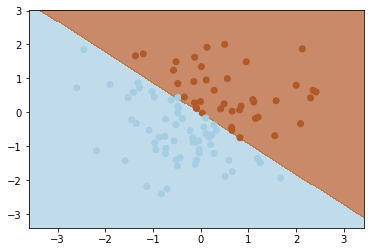

In [26]:
clf_lin = SVM(C=1, kernel=Kernel.linear())
plot(clf_lin, samples, labels, 200)

In [27]:
# Using sklearn

import numpy as np
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

X = np.array([[-1, -1], [-2, -1], [1, 1], [2, 1]])
y = np.array([1, 1, 2, 2])

clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X, y)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='auto', kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [28]:
print(clf.predict([[-0.8, -1]]))

[1]


In [29]:
# Using linear kernel

from sklearn.svm import SVC

classifier = SVC(kernel = 'linear', random_state = 0)
classifier.fit(train_set_x.T, train_set_y.T)

/home/ihor/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)

In [30]:
from sklearn.metrics import confusion_matrix, accuracy_score

y_pred = classifier.predict(test_set_x.T)

cm = confusion_matrix(test_set_y.T, y_pred)
print(cm)
accuracy_score(test_set_y.T, y_pred)

[[53  0]
 [ 3 44]]


0.97

In [31]:
# Using gaussian kernel

classifier = SVC(kernel = 'rbf', random_state = 0)
classifier.fit(train_set_x.T, train_set_y.T)

/home/ihor/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)

In [32]:
y_pred = classifier.predict(test_set_x.T)

cm = confusion_matrix(test_set_y.T, y_pred)
print(cm)
accuracy_score(test_set_y.T, y_pred)

[[52  1]
 [ 6 41]]


0.93